<a href="https://colab.research.google.com/github/Mayank-004/Covid-19-/blob/main/Covid_19_Identification_using_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install imutils


In [27]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import shutil
import cv2
import os

In [11]:
# Path for Dataset for Normal Patience's X-ray images
normal_dataset_path ='/content/drive/MyDrive/Covid 19/chest_xray/train/NORMAL'

# Path for Dataset for Covid Patience's X-ray images
covid_dataset_path = '/content/drive/MyDrive/Covid 19'

# Dataset created for training purpose after labeling
Final_dataset_path = '/content/drive/MyDrive/Covid 19/CreatedImages'



In [4]:
samples = 25


In [12]:
# construct the path to the metadata CSV file and load it
csvPath = os.path.sep.join([covid_dataset_path, "metadata.csv"])
df = pd.read_csv(csvPath)

# loop over the rows of the COVID-19 data frame
for (i, row) in df.iterrows():
    # if (1) the current case is not COVID-19 or (2) this is not
    # a 'PA' view, then ignore the row
    if row["finding"] != "COVID-19" or row["view"] != "PA":
        continue

    # build the path to the input image file
    imagePath = os.path.sep.join([covid_dataset_path, "images", row["filename"]])

    # if the input image file does not exist (there are some errors in
    # the COVID-19 metadeta file), ignore the row
    if not os.path.exists(imagePath):
        continue

    # extract the filename from the image path and then construct the
    # path to the copied image file
    filename = row["filename"].split(os.path.sep)[-1]
    outputPath = os.path.sep.join([f"{Final_dataset_path}/Covid", filename])

    # copy the image
    shutil.copy2(imagePath, outputPath)

In [13]:
#basePath = os.path.sep.join([normal_dataset_path, "train", "NORMAL"])
#imagePaths = list(paths.list_images(basePath))
imagePaths = list(paths.list_images(normal_dataset_path))

# randomly sample the image paths
random.seed(42)
random.shuffle(imagePaths)
imagePaths = imagePaths[:samples]

# loop over the image paths
for (i, imagePath) in enumerate(imagePaths):
    # extract the filename from the image path and then construct the
    # path to the copied image file
    filename = imagePath.split(os.path.sep)[-1]
    outputPath = os.path.sep.join([f"{Final_dataset_path}/Normal", filename])

    # copy the image
    shutil.copy2(imagePath, outputPath)

In [17]:
## User Defined function for plotting X ray images

def ceildiv(a, b):
    return -(-a // b)

def plots_from_files(imspaths, figsize=(10,5), rows=1, titles=None, maintitle=None):
    """Plot the images in a grid"""
    f = plt.figure(figsize=figsize)
    if maintitle is not None: plt.suptitle(maintitle, fontsize=10)
    for i in range(len(imspaths)):
        sp = f.add_subplot(rows, ceildiv(len(imspaths), rows), i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        img = plt.imread(imspaths[i])
        plt.imshow(img)

In [19]:
Normal_images = list(paths.list_images(f"{Final_dataset_path}/Normal"))
Covid_images = list(paths.list_images(f"{Final_dataset_path}/Covid"))

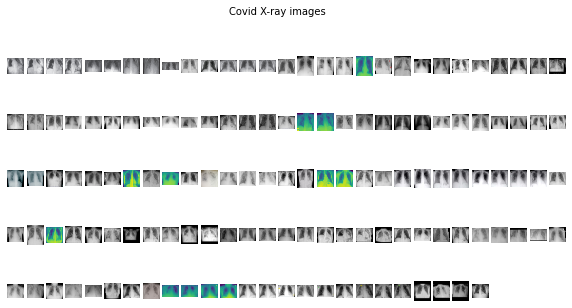

In [20]:
plots_from_files(Covid_images, rows=5, maintitle="Covid X-ray images")


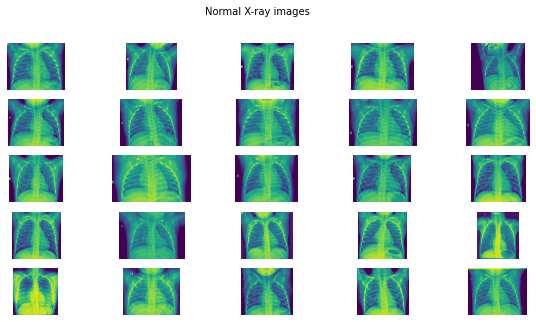

In [21]:
plots_from_files(Normal_images, rows=5, maintitle="Normal X-ray images")


In [22]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-3
EPOCHS = 10
BS = 8

In [28]:
# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")
imagePaths = list(paths.list_images(Final_dataset_path))
data = []
labels = []
# loop over the image paths
for imagePath in imagePaths:
    # extract the class label from the filename
    label = imagePath.split(os.path.sep)[-2]
    # load the image, swap color channels, and resize it to be a fixed
    # 224x224 pixels while ignoring aspect ratio
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    # update the data and labels lists, respectively
    data.append(image)
    labels.append(label)
# convert the data and labels to NumPy arrays while scaling the pixel
# intensities to the range [0, 1]
data = np.array(data) / 255.0
labels = np.array(labels)

[INFO] loading images...


In [29]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.20, stratify=labels, random_state=42)
# initialize the training data augmentation object
trainAug = ImageDataGenerator(rotation_range=15, fill_mode="nearest")

In [74]:
labels

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.

In [31]:
# load the VGG16 network, ensuring the head FC layer sets are left
# off
baseModel = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False

58892288/58889256 [==============================] - 0s 0us/step


In [ ]:
trainY

In [33]:
# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

# train the head of the network
print("[INFO] training head...")
H = model.fit_generator(
    trainAug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

[INFO] compiling model...
[INFO] training head...


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
16/16 [==============================] - 72s 4s/step - loss: 0.6104 - accuracy: 0.6935 - val_loss: 0.4174 - val_accuracy: 0.8529
Epoch 2/10
16/16 [==============================] - 71s 4s/step - loss: 0.4565 - accuracy: 0.8468 - val_loss: 0.3926 - val_accuracy: 0.8529
Epoch 3/10
16/16 [==============================] - 71s 4s/step - loss: 0.4688 - accuracy: 0.8306 - val_loss: 0.3774 - val_accuracy: 0.8529
Epoch 4/10
16/16 [==============================] - 71s 4s/step - loss: 0.4238 - accuracy: 0.8387 - val_loss: 0.3582 - val_accuracy: 0.8529
Epoch 5/10
16/16 [==============================] - 71s 4s/step - loss: 0.3249 - accuracy: 0.8710 - val_loss: 0.3357 - val_accuracy: 0.8529
Epoch 6/10
16/16 [==============================] - 71s 4s/step - loss: 0.3379 - accuracy: 0.8548 - val_loss: 0.3261 - val_accuracy: 0.8529
Epoch 7/10
16/16 [==============================] - 71s 4s/step - loss: 0.3799 - accuracy: 0.8387 - val_loss: 0.3009 - val_accuracy: 0.8529
Epoch 8/10
16/16 [==

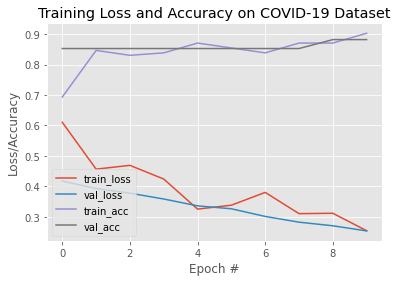

In [36]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

In [55]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predtrain = model.predict(trainX, batch_size=BS)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
#predtrainxs = np.argmax(predtrain, axis=1)
# show a nicely formatted classification report
#print(classification_report(testY.argmax(axis=1), predtrainxs, target_names=lb.classes_))

[INFO] evaluating network...


In [56]:
predtest = model.predict(testX, batch_size=BS)


In [ ]:
testX

In [ ]:
'''# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(trainX, batch_size=BS)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
#predIdxs = np.argmax(predIdxs, axis=1)
# show a nicely formatted classification report
#print(classification_report(trainY.argmax(axis=1), predIdxs, target_names=lb.classes_))
predIdxs'''

In [189]:
'''for i in range(len(trainY)):
    if(trainY[i,1]==1):
        print(predIdxs[i])'''

[0.77863365 0.2213664 ]
[0.808299   0.19170101]
[0.88948214 0.11051788]
[0.8272546  0.17274539]
[0.8399746  0.16002536]
[0.7582413  0.24175867]
[0.82967514 0.17032482]
[0.7916851  0.20831491]
[0.808297   0.19170302]
[0.7763992  0.22360083]
[0.8563327  0.14366725]
[0.80671996 0.19328004]
[0.8703141  0.12968585]
[0.9212973  0.07870273]
[0.92069197 0.07930803]
[0.8907042  0.10929572]
[0.7641205  0.23587954]
[0.7808533  0.21914676]
[0.74616545 0.2538345 ]
[0.88475454 0.11524549]


In [61]:
decisions = (predtrain[:,0]<= 0.85).astype(int)
decisions

array([0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [58]:
predtrain[:,0]<= 0.85

array([False, False,  True, False, False, False, False,  True, False,
       False,  True, False, False,  True,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False, False, False,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False,  True,  True, False, False,  True,  True, False,
       False, False, False, False, False, False, False,  True, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True, False,
       False, False, False,  True, False, False, False, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [ ]:
predIdxs

In [ ]:
'''# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
cm = confusion_matrix(testY.argmax(axis=1), decisions)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
# show the confusion matrix, accuracy, sensitivity, and specificity
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))'''

In [205]:
'''# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
cm = confusion_matrix(trainY.argmax(axis=1), decisions)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
# show the confusion matrix, accuracy, sensitivity, and specificity
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))'''

[[111   1]
 [  7  13]]
acc: 0.9394
sensitivity: 0.9911
specificity: 0.6500


In [201]:
trainY.argmax(axis=1)

array([0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [81]:
resultstrain = [];
thresholds = np.linspace(0,1,50)
for i in thresholds:
    to_append=[]
    decisions = (predtrain[:,0]<=i).astype(int)
    cm = confusion_matrix(trainY.argmax(axis=1), decisions)
    total = sum(sum(cm))
    acc = (cm[0, 0] + cm[1, 1]) / total
    sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
    specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
    to_append = [i,acc,sensitivity,specificity]
    resultstrain.append(to_append)

# show the confusion matrix, accuracy, sensitivity, and specificity
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))


[[  0 112]
 [  0  20]]
acc: 0.1515
sensitivity: 0.0000
specificity: 1.0000


In [71]:
resultstrain= pd.DataFrame(resultstrain, columns=['Threshold','Accuracy','Sensitivity','Specificity'])

In [ ]:
resultstrain

In [77]:
resultstest = [];
thresholds = np.linspace(0,1,50)
for i in thresholds:
    to_append=[]
    decisionstest = (predtest[:,0]<=i).astype(int)
    cm = confusion_matrix(testY.argmax(axis=1), decisionstest)
    total = sum(sum(cm))
    acc = (cm[0, 0] + cm[1, 1]) / total
    sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
    specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
    to_append = [i,acc,sensitivity,specificity]
    resultstest.append(to_append)

In [79]:
resultstest= pd.DataFrame(resultstest, columns=['Threshold','Accuracy','Sensitivity','Specificity'])

In [80]:
resultstest

,Threshold,Accuracy,Sensitivity,Specificity
0,0.000000,0.852941,1.000000,0.0
1,0.020408,0.852941,1.000000,0.0
2,0.040816,0.852941,1.000000,0.0
3,0.061224,0.852941,1.000000,0.0
4,0.081633,0.852941,1.000000,0.0
5,0.102041,0.852941,1.000000,0.0
6,0.122449,0.852941,1.000000,0.0
7,0.142857,0.852941,1.000000,0.0
8,0.163265,0.852941,1.000000,0.0
9,0.183673,0.852941,1.000000,0.0
